In [1]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
# n-gram individual BLEU
from nltk.translate.bleu_score import sentence_bleu
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

13510573713/13510573713 [==============================] - 327s 0us/step


In [9]:
# Read the json file
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# Store captions and image names in vectors
all_captions = []
all_img_name_vector = []

for annot in annotations['annotations']:
    caption = '<start> ' + annot['caption'] + ' <end>'
    image_id = annot['image_id']
    full_coco_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (image_id)

    all_img_name_vector.append(full_coco_image_path)
    all_captions.append(caption)

# Shuffle captions and image_names together
# Set a random state
train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=1)

num_examples = 100000
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]

In [10]:
len(train_captions), len(all_captions)

(100000, 414113)

In [13]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img, image_path

In [14]:
image_model = tf.keras.applications.vgg19.VGG19(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [15]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

In [16]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [17]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [18]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [19]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [20]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [21]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

In [22]:
# Create training and validation sets using an 80-20 split
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)

print(len(img_name_val))

20000


In [23]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(80000, 80000, 20000, 20000)

In [24]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 81

In [25]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [26]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [27]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [28]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [29]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [30]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [31]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [32]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [33]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [34]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [35]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [36]:
import time

EPOCHS = 25  # Set the number of epochs to 25

# Ensure that start_epoch is defined. If it's not, initialize it to 0.
# Example: start_epoch = 0
# Make sure to define or adjust this according to your requirements.

for epoch in range(start_epoch, EPOCHS):
    start = time.time()  # Start time for the epoch
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(
                epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))

    # Storing the epoch end loss value to plot later
    # Make sure loss_plot and num_steps are defined
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
        ckpt_manager.save()  # Assuming ckpt_manager is defined

    epoch_time = time.time() - start  # Time taken for the current epoch
    print('Epoch {} Loss {:.6f}'.format(epoch + 1, total_loss / num_steps))
    print('Time taken for epoch {}: {:.2f} sec\n'.format(epoch + 1, epoch_time))


Epoch 1 Batch 0 Loss 1.8833
Epoch 1 Batch 100 Loss 1.0816
Epoch 1 Batch 200 Loss 0.9074
Epoch 1 Batch 300 Loss 0.8328
Epoch 1 Batch 400 Loss 0.7989
Epoch 1 Batch 500 Loss 0.7472
Epoch 1 Batch 600 Loss 0.7824
Epoch 1 Batch 700 Loss 0.7289
Epoch 1 Batch 800 Loss 0.7677
Epoch 1 Batch 900 Loss 0.6961
Epoch 1 Batch 1000 Loss 0.7953
Epoch 1 Batch 1100 Loss 0.7259
Epoch 1 Batch 1200 Loss 0.7795
Epoch 1 Loss 0.824508
Time taken for epoch 1: 193.32 sec

Epoch 2 Batch 0 Loss 0.7654
Epoch 2 Batch 100 Loss 0.6817
Epoch 2 Batch 200 Loss 0.6809
Epoch 2 Batch 300 Loss 0.6493
Epoch 2 Batch 400 Loss 0.7184
Epoch 2 Batch 500 Loss 0.6368
Epoch 2 Batch 600 Loss 0.6538
Epoch 2 Batch 700 Loss 0.6947
Epoch 2 Batch 800 Loss 0.6406
Epoch 2 Batch 900 Loss 0.6477
Epoch 2 Batch 1000 Loss 0.6752
Epoch 2 Batch 1100 Loss 0.6734
Epoch 2 Batch 1200 Loss 0.6761
Epoch 2 Loss 0.670559
Time taken for epoch 2: 128.84 sec

Epoch 3 Batch 0 Loss 0.5972
Epoch 3 Batch 100 Loss 0.6980
Epoch 3 Batch 200 Loss 0.7577
Epoch 3 Batch 

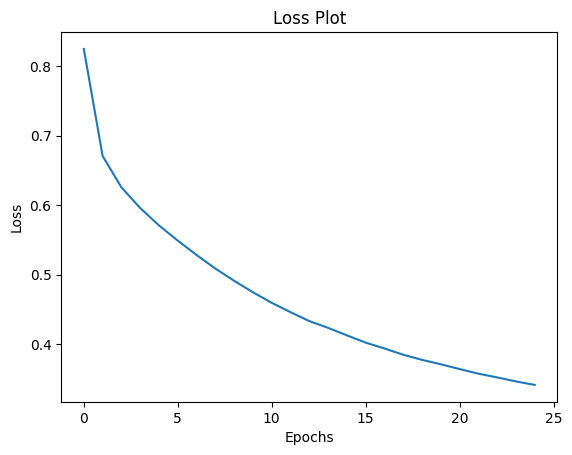

In [37]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

#saving model and data

In [38]:
!mkdir "/content/drive/My Drive/CaptioningModel"

In [39]:
import json
with open('/content/drive/My Drive/CaptioningModel/word_index.json', 'w') as fp:
  json.dump(tokenizer.word_index, fp)
with open('/content/drive/My Drive/CaptioningModel/index_word.json', 'w') as fp:
  json.dump(tokenizer.index_word, fp)


In [40]:
path = "/content/drive/My Drive/CaptioningModel/decoder"
decoder.save_weights(path)

path = "/content/drive/My Drive/CaptioningModel/encoder"
encoder.save_weights(path)

In [41]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [42]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [43]:
# captions on the validation set
import json
real = []
predicted =[]
jsonAnnotation = []
jsonPredected = []
count=0
for i in range(10000):
  rid = np.random.randint(0, len(img_name_val))
  image = img_name_val[rid]
  real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
  result, attention_plot = evaluate(image)

  img =  image[19 : len(image)]
  real_caption = real_caption.replace('<start>', ' ')
  real_caption = real_caption.replace('<end>', ' ')
  ls = {
      "name": str(img),
      "id" : str(rid),
      "caption" : real_caption
  }
  jsonAnnotation.append(ls)

  predictedCaption = ' '.join(result)
  predictedCaption = predictedCaption.replace('<start>', ' ')
  predictedCaption = predictedCaption.replace('<end>', ' ')

  pLs = {
      "image_id": rid ,
      "id":rid,
      "caption":predictedCaption
  }
  count = count +1
  jsonPredected.append(pLs)
  if(count%100 == 0):
    print("Done Steps "+ str((count)))

!mkdir "/content/drive/My Drive/Image-captioning-Researc-paper-implimentation-master"
with open('/content/drive/My Drive/Image-captioning-Researc-paper-implimentation-master/predictedCaption.json', 'w') as fp:
  json.dump(jsonPredected , fp)
with open('/content/drive/My Drive/Image-captioning-Researc-paper-implimentation-master/annotation.json', 'w') as fp:
  json.dump(jsonAnnotation , fp)

print("Done, Uploaded on Drive")
#plot_attention(image, result, attention_plot)
#Image.open(image)

Done Steps 100
Done Steps 200
Done Steps 300
Done Steps 400
Done Steps 500
Done Steps 600
Done Steps 700
Done Steps 800
Done Steps 900
Done Steps 1000
Done Steps 1100
Done Steps 1200
Done Steps 1300
Done Steps 1400
Done Steps 1500
Done Steps 1600
Done Steps 1700
Done Steps 1800
Done Steps 1900
Done Steps 2000
Done Steps 2100
Done Steps 2200
Done Steps 2300
Done Steps 2400
Done Steps 2500
Done Steps 2600
Done Steps 2700
Done Steps 2800
Done Steps 2900
Done Steps 3000
Done Steps 3100
Done Steps 3200
Done Steps 3300
Done Steps 3400
Done Steps 3500
Done Steps 3600
Done Steps 3700
Done Steps 3800
Done Steps 3900
Done Steps 4000
Done Steps 4100
Done Steps 4200
Done Steps 4300
Done Steps 4400
Done Steps 4500
Done Steps 4600
Done Steps 4700
Done Steps 4800
Done Steps 4900
Done Steps 5000
Done Steps 5100
Done Steps 5200
Done Steps 5300
Done Steps 5400
Done Steps 5500
Done Steps 5600
Done Steps 5700
Done Steps 5800
Done Steps 5900
Done Steps 6000
Done Steps 6100
Done Steps 6200
Done Steps 6300
D

Prediction Caption: a british airways jet plane flies through the sky <end>


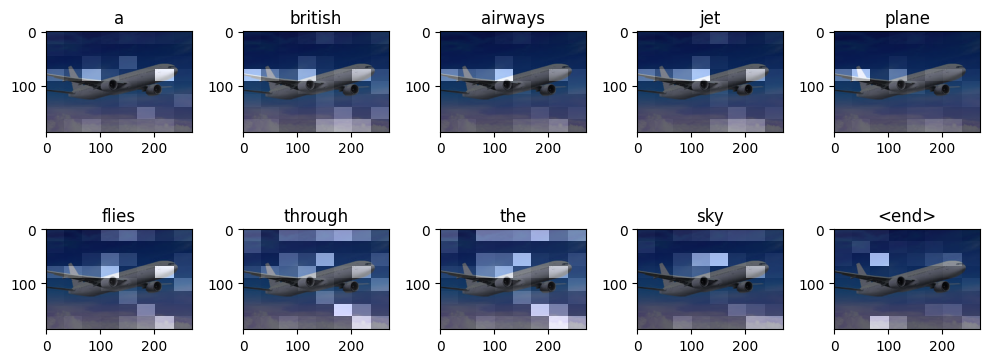

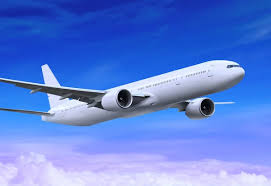

In [45]:
# image_url = 'https://homepages.cae.wisc.edu/~ece533/images/airplane.png'

image_url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTzCTOwIrSTiLJF2vJIiuqgY6x2nAzAAcQNrg&usqp=CAU'

image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension,
                                     origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)